<a href="https://colab.research.google.com/github/IsaacFigNewton/DAG-Based-Compression/blob/main/DAG_Text_Encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TODO



1.  Represent each token embedding with a sparse matrix of dimensions n x m where n=number of unique characters and m=number of unique character positions
2.  Represent vectorization of text as third dimension, with token vector scaling corresponding to token frequencies

# Install packages and import libraries

In [1]:
import math
import random
from queue import Queue
import numpy as np
import urllib.request as url
import pandas as pd

import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
# warnings.filterwarnings('ignore')

#Important functions

##Utility

In [2]:
def tokenize(text, token_dict, max_token_len):
    # filter to include only tokens shorter than the
    available_tokens = {token: freq for token, freq in token_dict.items() if len(token) <= max_token_len}

    # sort tokens by length and secondarily frequency
    best_tokens = sorted(list(available_tokens.items()),
                         key=lambda x: (-len(x[0]), -x[1]))

    # extract tokens from the ordered list
    tokenization = []
    while text != "":
        for token, freq in best_tokens:
            if text.startswith(token):
                tokenization.append(token)
                text = text[len(token):]

    return tokenization

In [3]:
def print_tree(tree, indent = 0):
    # Iterate over the child.suffixes (features) in the tree
    for child in tree.children:
        print(' ' * indent + str(child.suffix) + ": " + str(child.frequency))
        # If the child is a SuffixNode, recursively print the subtree
        if isinstance(child, SuffixNode):
            print_tree(child, indent + 4)
        else:
            print(' ' * (indent + 4) + "\"" + str(child.suffix) + "\": " + str(child.frequency))

In [56]:
def plot_dag(edge_set, scaling=100, edge_width=1, k=2):
    # Initialize a directed graph
    G = nx.DiGraph()
    # Add edges to the graph
    for parent, child, position in edge_set:
        G.add_edge(parent, child)#, weight=position)

    # Calculate figure size based on the number of nodes
    num_nodes = len(G.nodes)
    figsize = -3 + math.log2(num_nodes) * scaling/25
    font_size = 2 + math.sqrt(scaling)/5

    # Position nodes using the spring layout
    pos = nx.spring_layout(G, seed=42, k=k/num_nodes)

    # Calculate node sizes based on the length of the token text
    node_sizes = [scaling * len(node) for node in G.nodes()]

    plt.figure(figsize=(figsize, figsize), dpi=300)

    # Draw nodes with sizes proportional to the length of their text
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes)

    # Draw edges with widths based on edge weights
    nx.draw_networkx_edges(G,
                           pos,
                           edgelist=edge_set,
                           width=edge_width,
                           arrowstyle='-|>',
                           connectionstyle="arc3,rad=0.2")

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=font_size, font_family="sans-serif")

    # Draw edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)

    # Customize and show plot
    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

## Classes

### SuffixNode Class

In [5]:
class SuffixNode:
    def __init__(self,
                 suffix=None,
                 token=None,
                 frequency=0,
                 parent=None,
                 children=None):
        self.suffix = suffix
        self.token = token
        self.frequency = frequency

        self.parent = parent

        if children is None:
            children = set()  # Initialize children as an empty set
        self.children = children

    def __str__(self):
        return self.suffix


    def split_edge(self, child, i):
      old_suffix = child.suffix[i:]
      new_suffix = self.suffix[i:]

      # Replace the old entry for the current node with a new one for the edge split
      split_node = SuffixNode(suffix=child.suffix[:i],
                              frequency=child.frequency,
                              parent=self,
                              children=child.children)

      # Remove the old child and add the new split node
      self.children.remove(child)
      self.children.add(split_node)

      # Create a new node for the existing edge suffix
      new_child = SuffixNode(suffix=old_suffix,
                              frequency=1,
                              parent=split_node,
                              children=split_node.children)

      # Transfer the children to the new split node's child
      for grandchild in split_node.children:
          grandchild.parent = new_child

      # Create a new node for the new suffix
      #     and move both it and the previous suffix beneath the split node
      split_node.children = {new_child,
                              SuffixNode(suffix=new_suffix,
                                        frequency=1,
                                        parent=split_node)
      }


    def add_suffix(self, suffix):

        # Find the longest prefix match in the children
        for child in self.children:

            # Find the index of the longest common prefix
            i = 0
            while i < len(child.suffix) and i < len(suffix) and child.suffix[i] == suffix[i]:
                i += 1

            # If there is a common prefix
            if i > 0:
                # Update the frequency of the current node
                child.frequency += 1

                # If the common prefix is the entire child key, recurse into that child
                if i == len(child.suffix):
                    child.add_suffix(suffix[i:])

                # If the common prefix is only part of the child key, split the edge
                elif i < len(suffix):
                    self.split_edge(child, i)

                return

        # No matching prefix, add the suffix as a new child
        self.children.add(SuffixNode(suffix=suffix,
                                     frequency=1,
                                     parent=self))


    def build_tree(self, string):
        # loop through the string, starting with the last character
        for i in range(0, len(string)):
            suffix = string[len(string) - i - 1:]

            # add the suffix to the tree
            self.add_suffix(suffix)


    def prune_tree(self, threshold=2):
        # If the node has no children, return
        if not self.children:
            print("no children")
            return

        children_to_kill = set()
        # Recursively prune the tree
        for child in self.children:

            if isinstance(child, SuffixNode):
                # if the child is above the threshold or it's a single character token node
                if child.frequency >= threshold or child.parent is None:
                    # print("not removed")
                    child.prune_tree(threshold)
                else:
                    # print("removed")
                    children_to_kill.add(child)

        for child in children_to_kill:
            # if the token's frequency falls below the threshold, prune it
            self.children.remove(child)


    # set all the suffix tree nodes' token properties
    # return an aggregated set of all the tokens
    def get_tokens(self, prev_token=""):
        tokens = dict()

        for child in self.children:
            if isinstance(child, SuffixNode):
                token = prev_token + child.suffix

                # set the child's token for later use
                child.token = token

                # add the accumulation of the current suffix with previous suffixes
                #   as a new token in the token set, with the previously found frequency
                tokens[token] = child.frequency
                # Recursively get tokens from the child
                tokens.update(child.get_tokens(token))

        return tokens

In [6]:
def build_suffix_tree(text, threshold):
  suffix_tree = SuffixNode(children = { SuffixNode(suffix=unique_char) for unique_char in set(text) })
  suffix_tree.build_tree(text)
  suffix_tree.prune_tree(threshold=threshold)
  tokens = suffix_tree.get_tokens()

  return suffix_tree, tokens

### CompositionDAGNode

In [7]:
class DAGStore:
  def __init__(self, vertices=None, edge_set=None):
      if vertices is None:
        vertices = dict()
      if edge_set is None:
        edge_set = set()

      self.vertices = vertices
      self.edge_set = edge_set

In [8]:
class CompositionDAGNode:
    def __init__(self,
                 token=None,
                 frequency=0,
                 parents=None,
                 children=None,
                 dag_store=None):
        self.token = token
        self.frequency = frequency

        if parents is None:
            parents = list()
        self.parents = parents

        if children is None:
            children = set()
        self.children = children

        if dag_store is None:
            dag_store = DAGStore()
        self.dag_store = dag_store

    def __str__(self):
        return self.token


    # make an edge between the current token and a successor
    def add_edge(self, child):
        # Add the larger token as a child of this token
        self.children.add(child)

        # Add this token to the list of parents composing the larger token
        child.parents.append(self)

        # Add an edge to the edge list, using the current token's position
        #   in the child token as the edge weight
        self.dag_store.edge_set.add((self.token, child.token, len(child.parents) - 1))


    def remove_edge(self, child, parent_pos):
        # Remove the edge from the edge list
        self.dag_store.edge_set.remove((self, child, parent_pos))

        # Ensure that there is a parent in the provided position
        if child.parents[parent_pos] is not None:
            # Remove this token as one of the parents composing the larger token,
            #   in position parent_pos
            child.parents[parent_pos] = None
        else:
            raise ValueError("No parent to remove at position " + str(parent_pos) + " for token " + str(child))

        # Remove the larger token as a child of this token
        self.children.remove(child)


    def replace_edge(self, old_child, new_child, parent_pos):
        # Remove the old edge
        self.remove_edge(old_child, parent_pos)

        # Add the new edge
        self.add_edge(new_child, parent_pos)


    # since this is recursively saving smaller tokens, it's basically depth-first
    def build_subgraph(self, all_tokens, suffix_tokenization):
      vertices = self.dag_store.vertices

      for token in suffix_tokenization:

        # if the predecessor token is not in the vertex store,
        #   recursively build a sub-graph of suffix tokens
        if token not in vertices.keys():
            # create a new dag node for the current token
            #   and put it in the vertex store
            vertices[token] = CompositionDAGNode(token=token,
                                                 frequency=all_tokens[token],
                                                 dag_store = self.dag_store)

            # break the missing token into even smaller tokens using the largest available smaller tokens
            curr_suffix_tokenization = tokenize(token, all_tokens, len(token) - 1)
            # build a subgraph from the smaller tokens
            temp_vert = vertices[token]
            temp_vert, additional_vertices = temp_vert.build_subgraph(all_tokens, curr_suffix_tokenization)
            vertices.update(additional_vertices)

            vertices[token] = temp_vert

        # base case: if the predecessor is in the vertex store
        #   add an edge from the current node's predecessor to it
        vertices[token].add_edge(self)

      return self, vertices


    # do breadth-first accumulation of the suffix tree into the dag
    def suffix_tree_to_dag(self, suffix_tree):
        all_tokens = suffix_tree.get_tokens()
        vertices = self.dag_store.vertices
        vertices[self.token] = self

        suffix_node_queue = Queue()
        suffix_node_queue.put(suffix_tree)

        while not suffix_node_queue.empty():
            # get the next suffix node from the queue
            current_suffix_node = suffix_node_queue.get()

            # create a dag vertex and add it to the set of vertices
            vert = CompositionDAGNode(token=current_suffix_node.token,
                                      frequency=current_suffix_node.frequency,
                                      dag_store = self.dag_store)
            vertices[vert.token] = vert

            # if it's the root of the base dag or one of the top-level tokens, just add it to the vertex dict
            if current_suffix_node.parent is None or current_suffix_node.parent.token is None:
                vertices[current_suffix_node.token] = vert
                # add an edge from the base graph's root to the top-level token
                self.add_edge(vert)

            # otherwise, add edges
            else:
                # tokenize the current token using the largest available smaller tokens
                current_tokenization = tokenize(current_suffix_node.token,
                                               all_tokens,
                                               len(current_suffix_node.token) - 1)

                temp_vert = vert
                temp_vert, additional_vertices = temp_vert.build_subgraph(all_tokens, current_tokenization)
                vertices[vert.token] = temp_vert
                vertices.update(additional_vertices)

            # add all the current node's children to the queue
            for child in current_suffix_node.children:
                suffix_node_queue.put(child)

        self.dag_store.edge_set = {(pre, cum, pos) for pre, cum, pos in composition_dag.dag_store.edge_set if pre is not None}


    def print_dag(self, indent = 0):
        # Iterate over the child.suffixes (features) in the tree
        for child in self.children:
            print(' ' * indent + str(child.token) + ": " + str(child.frequency))
            # If the child is a CompositionDAGNode, recursively print the subgraphs
            if isinstance(child, CompositionDAGNode):
                child.print_dag(indent + 4)
            else:
                print(' ' * (indent + 4) + "\"" + str(child.suffix) + "\": " + str(child.frequency))

#Testing

In [31]:
# test_url = "https://courses.cs.washington.edu/courses/cse163/20wi/files/lectures/L04/bee-movie.txt"
# with url.urlopen(test_url) as f:
#     text = f.read().decode('utf-8')
# # previously 454:500
# text = text[:500]
text = "Mary had a little lamb, little lamb, little lamb"

tests = [("CAGTCAGG", 2),
         (text, 2)]

print(text[:50])

Mary had a little lamb, little lamb, little lamb


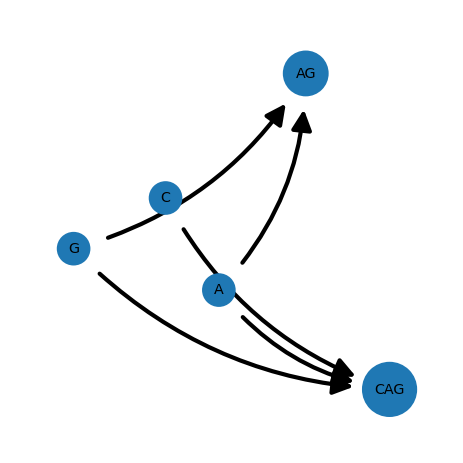


Tokens
{'T': 1, 'C': 2, 'CAG': 2, 'A': 2, 'AG': 2, 'G': 3}


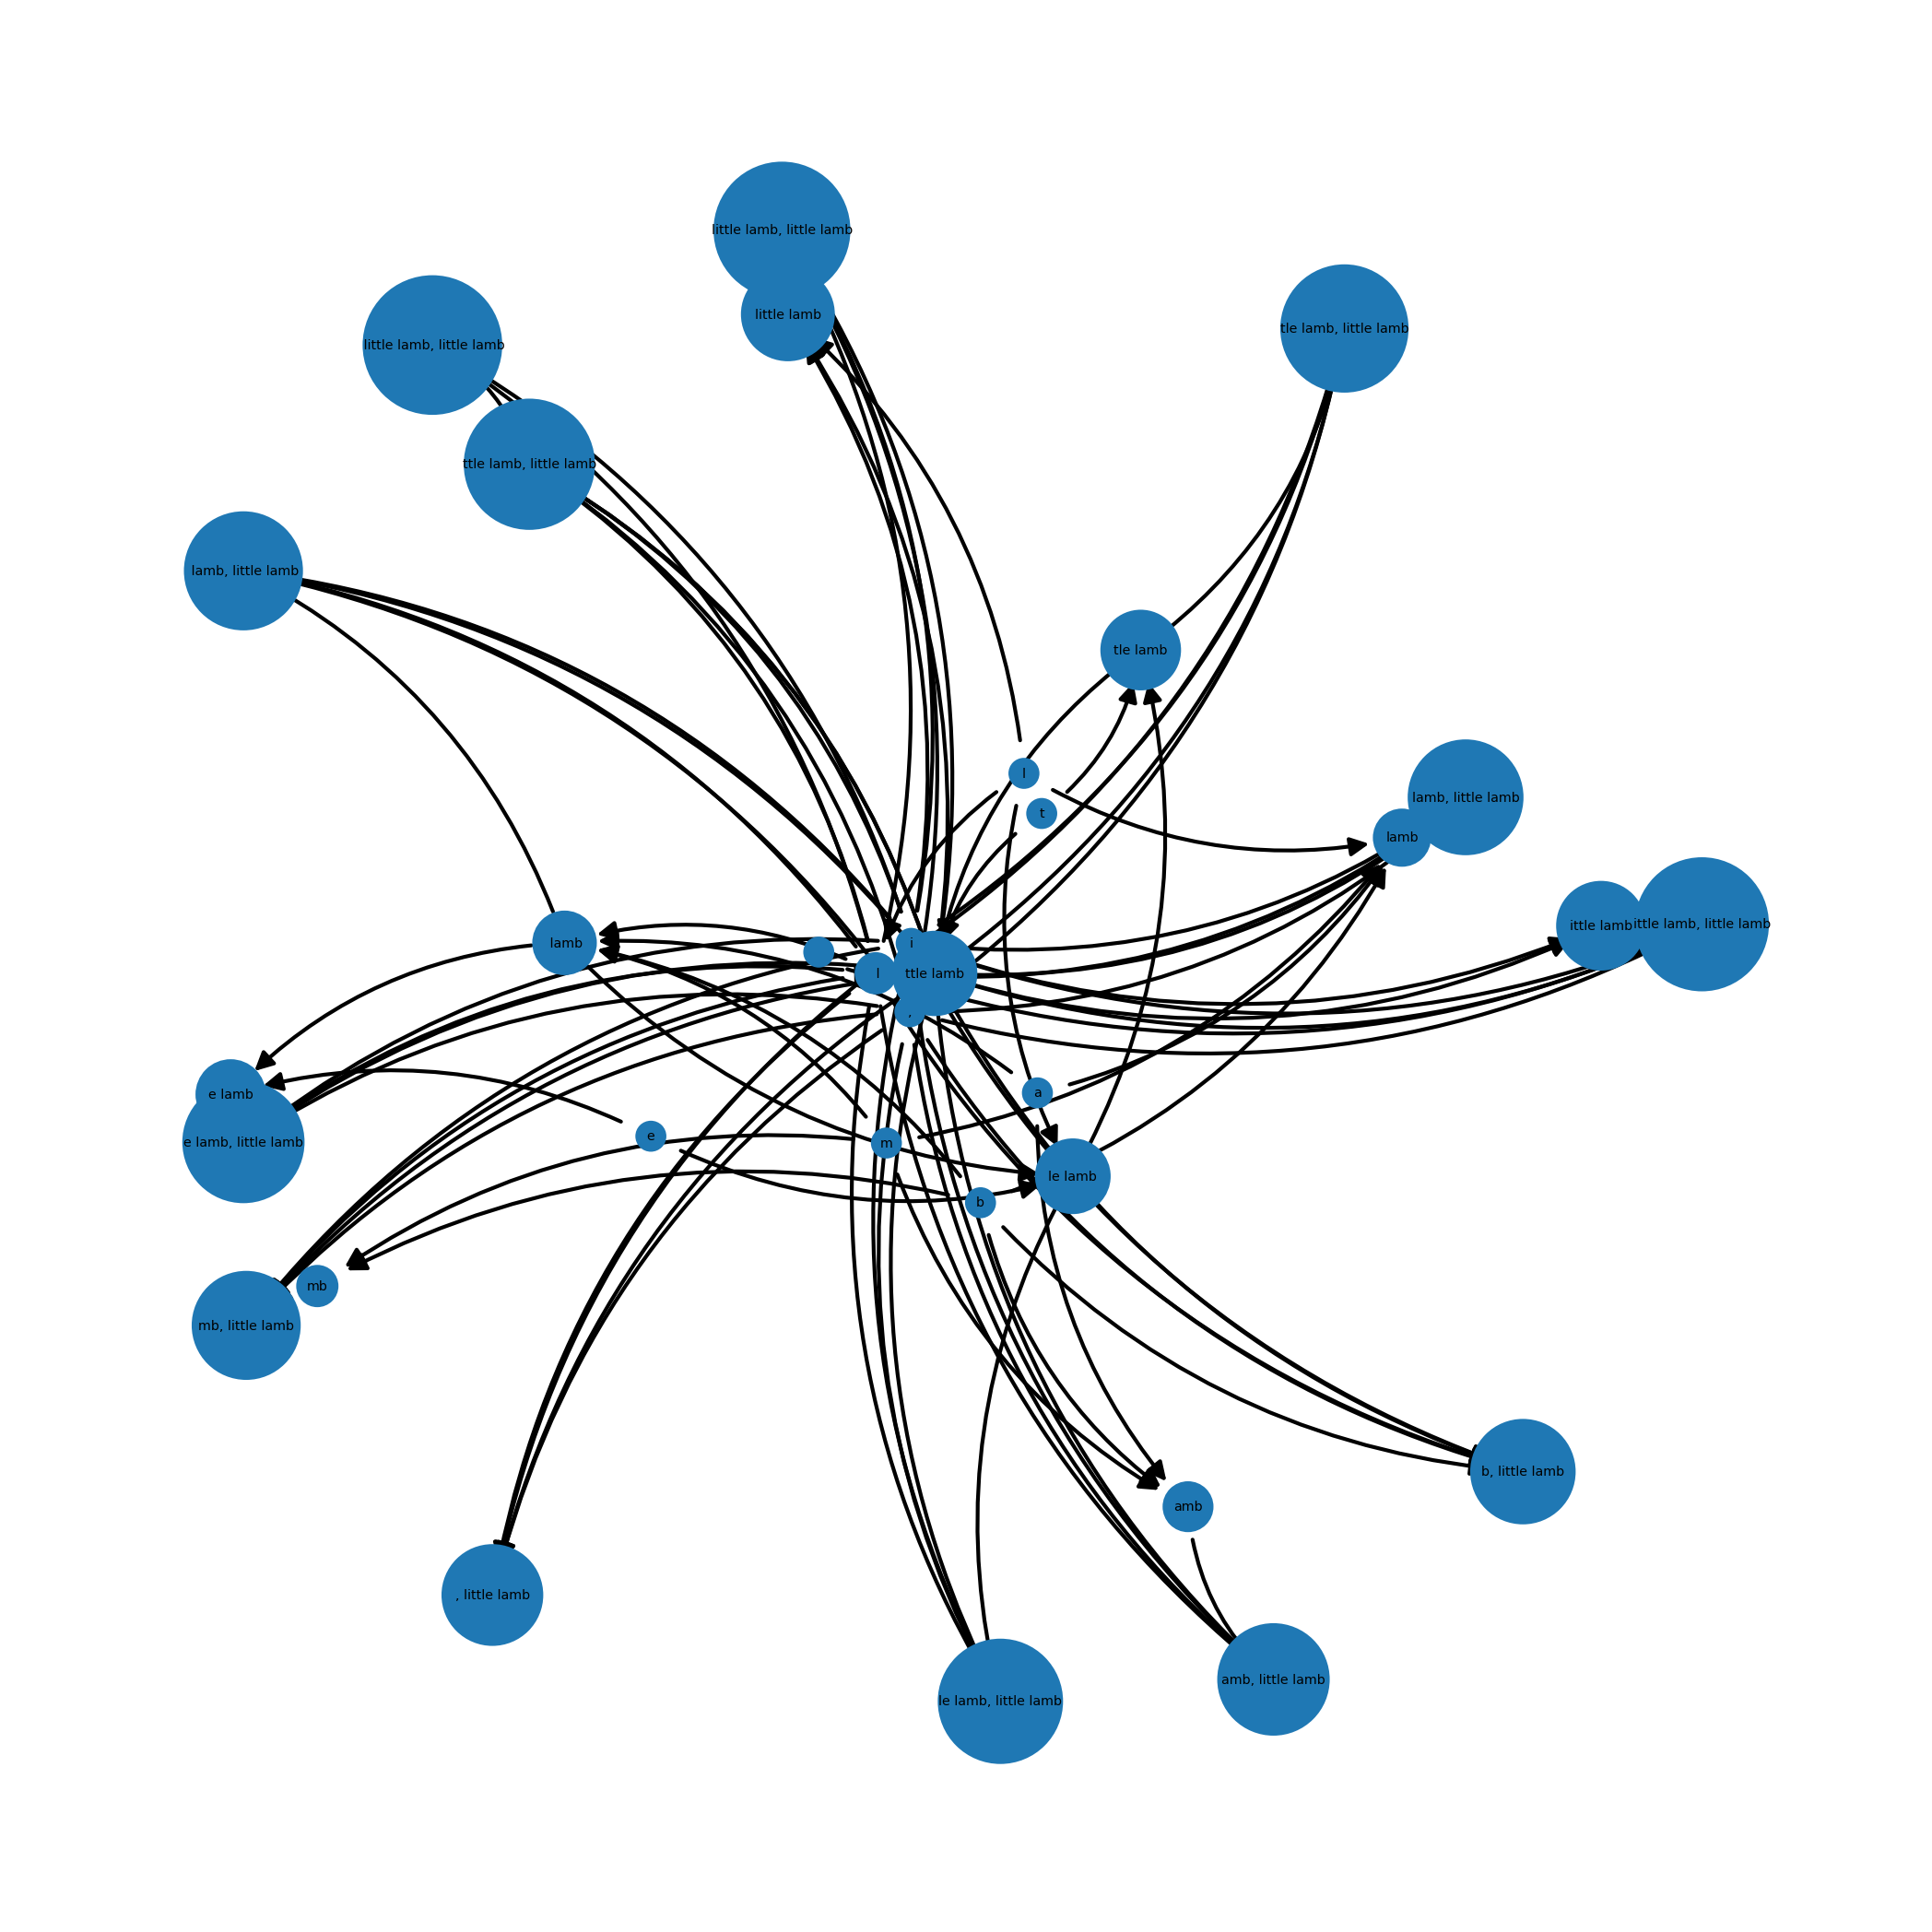


Tokens
{'d': 1, 'i': 3, 'ittle lamb': 3, 'ittle lamb, little lamb': 2, 'r': 1, 'm': 3, 'mb': 3, 'mb, little lamb': 2, ',': 2, ', little lamb': 2, 'y': 1, 'h': 1, ' ': 8, ' l': 6, ' lamb': 3, ' lamb, little lamb': 2, ' little lamb, little lamb': 2, 'e': 3, 'e lamb': 3, 'e lamb, little lamb': 2, 'l': 9, 'little lamb': 3, 'little lamb, little lamb': 2, 'le lamb': 3, 'le lamb, little lamb': 2, 'lamb': 3, 'lamb, little lamb': 2, 'M': 1, 'b': 3, 'b, little lamb': 2, 'a': 6, 'amb': 3, 'amb, little lamb': 2, 't': 6, 'ttle lamb': 3, 'ttle lamb, little lamb': 2, 'tle lamb': 3, 'tle lamb, little lamb': 2}


In [57]:
tokenizations = dict()
for test in tests:
  suffix_tree, tokenizations[test] = build_suffix_tree(test[0], test[1])

  composition_dag = CompositionDAGNode()
  composition_dag.suffix_tree_to_dag(suffix_tree)

  edge_set = {(pre, cum, pos+1) for pre, cum, pos in composition_dag.dag_store.edge_set if pre is not None}
  plot_dag(edge_set, scaling=50, edge_width=1, k=5)

  print()
  print("Tokens")
  print(tokenizations[test])

In [24]:
# # Initialize an empty dictionary to store token frequencies
# all_tokens = {}

# for test, tokens in tokenizations.items():
#     freq_col_name = "text_" + str(test[0][:5]) + "_threshold_" + str(test[1]) + '__frequency'
#     for token, frequency in tokens.items():
#         if token not in all_tokens:
#             all_tokens[token] = {}
#         all_tokens[token][freq_col_name] = frequency

# # Create the DataFrame from the collected token frequencies
# df = pd.DataFrame.from_dict(all_tokens, orient='index')
# df.index.name = 'token'
# df.fillna(0, inplace=True)  # Fill any missing frequencies with 0
# df = df.astype(int)  # Convert all frequency columns to integers
# df.reset_index(inplace=True)
# # df.rename(columns={'index': 'token'}, inplace=True

# print(df.head(10))
# print()
# print(df.shape)

In [25]:
# longest_token = df[df["token"].apply(lambda x: len(x)) == max(len(token) for token in df["token"])]
# longest_token